In [7]:
from pathlib import Path

import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tree_detection_framework.detection.detector import (
    DeepForestDetector,
    Detectree2Detector,
)
from tree_detection_framework.detection.models import DeepForestModule, Detectree2Module
from tree_detection_framework.utils.benchmarking import (
    get_benchmark_detections,
    evaluate_detections,
)
from tree_detection_framework.constants import DATA_FOLDER, CHECKPOINTS_FOLDER

In [8]:
# Setup path to NEON annotations and RGB folders. See the README for download instructions.
RGB_DIR = str(Path(DATA_FOLDER, "neon-benchmark", "RGB"))
ANN_DIR = str(Path(DATA_FOLDER, "neon-benchmark", "annotations"))


# Setup the parameters dictionary use Detectree2
DETECTREE2_MODEL_PARAMS = {
    "update_model": str(
        Path(CHECKPOINTS_FOLDER, "detectree2", "230103_randresize_full.pth")
    )
}

DATASET_NAME = "neon"
NMS_THRESHOLD = 0.05
CONFIDENCE_THRESHOLD = 0.1

# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# This model uses pretrained weights from DeepForest
module = DeepForestModule(use_hugging_face_weights=True).to(DEVICE)
deepforest_detector = DeepForestDetector(module)

# This model uses pretrained weights from Detectree2
module = Detectree2Module(DETECTREE2_MODEL_PARAMS)
detectree2_detector = Detectree2Detector(module)

Reading config file: /ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /ofo-share/repos-amritha/tree-detection-framework/checkpoints/detectree2/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /ofo-share/repos-amritha/tree-detection-framework/checkpoints/detectree2/230103_randresize_full.pth ...


In [9]:
# Load NEON and get detections
mappings = get_benchmark_detections(
    dataset_name=DATASET_NAME,
    images_dir=RGB_DIR,
    annotations_dir=ANN_DIR,
    detectors={"deepforest": deepforest_detector, "detectree2": detectree2_detector},
    nms_threshold=NMS_THRESHOLD,
    min_confidence=CONFIDENCE_THRESHOLD,
    nms_on_polygons=True,
)

INFO:root:Units set in PIXELS
INFO:root:Running detector: deepforest
Performing prediction on batches: 100%|██████████| 194/194 [00:06<00:00, 31.19it/s]
INFO:root:Running detector: detectree2
Performing prediction on batches: 100%|██████████| 194/194 [00:51<00:00,  3.75it/s]


In [10]:
evaluate_detections(mappings)

INFO:root:Detectors to be evaluated: ['deepforest', 'detectree2']


'deepforest': Precision=0.6153276843131942, Recall=0.7659847511899057, F1-Score=0.6824402807859108
'detectree2': Precision=0.25007214186010845, Recall=0.4988839225324311, F1-Score=0.33314897089042167


Visulaizing the predictions
--

<Axes: >

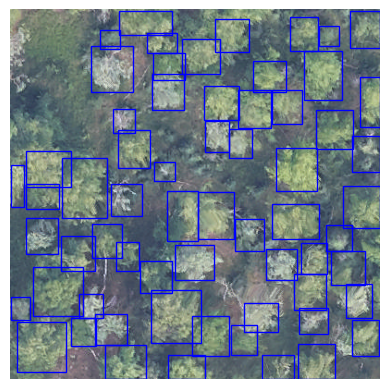

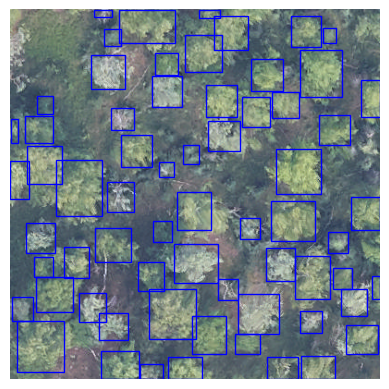

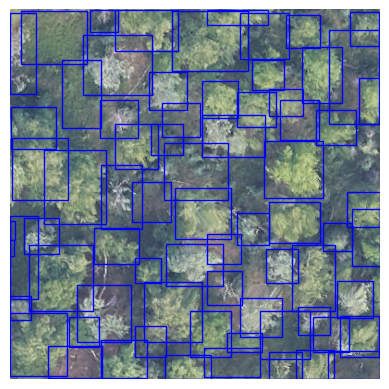

In [11]:
def create_plot_with_preds(img, gt_boxes):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(img)
    for bbox in gt_boxes:
        xmin, ymin, xmax, ymax = bbox.bounds
        # Create a Rectangle patch (xy, width, height)
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=1, edgecolor="b", facecolor="none"
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
    return ax


example_img = list(mappings.keys())[6]
img = cv2.imread(example_img, cv2.IMREAD_COLOR_RGB)
create_plot_with_preds(img, mappings[example_img]["gt"])
create_plot_with_preds(img, mappings[example_img]["deepforest"])
create_plot_with_preds(img, mappings[example_img]["detectree2"])